In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model
try:
    from peft import TaskType
    task_type = TaskType.SEQ_CLS
except ImportError:
    # For older PEFT versions, use string directly
    task_type = "SEQ_CLS"
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import Dataset, WeightedRandomSampler
from torch import nn
from sklearn.model_selection import train_test_split

from peft import LoraConfig
from transformers import TrainingArguments
!pip list




Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.10.post3
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.3
aiosignal                                1.4.0
aiosqlite                                0.22.1
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.18.1
altair                                   5.5.0
annotated-doc                            0.0.4
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                         

In [ ]:
drive.mount('/content/drive')
truth_df = pd.read_csv('/content/drive/MyDrive/TruthSocial/truth_cleand.csv')
print(truth_df.shape)
truth_df.head()

Mounted at /content/drive
(656365, 14)


,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,0.851504,neutral,0,0.010807
1,807614,6,20054,0,0,0,enough is enough! retruth,0,0.001936,1,0.489587,neutral,0,0.029001
2,807619,7,20054,0,0,0,@user,0,0.001936,1,0.681377,neutral,0,0.037486
3,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844
4,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,0.003288,1,0.861522,neutral,0,0.011909




> Blockzitat einfügen



In [ ]:
silver_label_timestamp=[5,6,7]
min_length_for_truth =80
max_length_for_truth =500


995


Text(0, 0.5, 'Frequency')

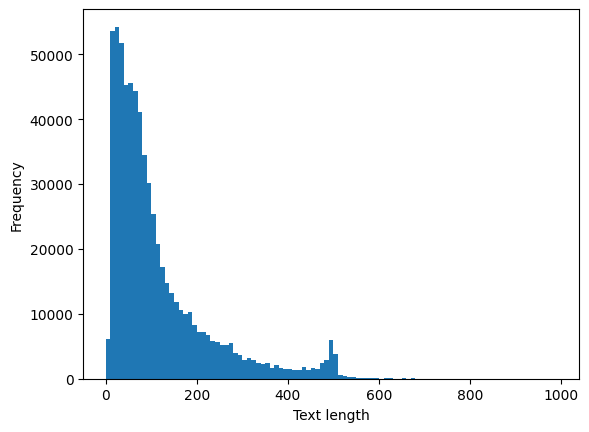

In [ ]:
#histogram of text length in 10 steps
import matplotlib.pyplot as plt
import numpy as np
import re
def clean_text(t):
    if pd.isna(t):           # prüft auf NaN
        return ""            # oder None, je nach Wunsch
    t = str(t).lower()       # sicherstellen, dass es ein String ist
    t = re.sub(r"http\S+", "", t)    # URLs entfernen
    t = re.sub(r"@\w+", "@user", t)  # Mentions normalisieren
    t = re.sub(r"\s+", " ", t).strip()
    return t

truth_df['text'] = truth_df['text'].apply(clean_text)
text_lengths = [len(text) for text in truth_df['text']]
print(max(text_lengths))
plt.hist(text_lengths, bins=np.arange(0, max(text_lengths), 10))
plt.xlabel('Text length')
plt.ylabel('Frequency')




In [ ]:
#load weak lables:
weak_labels = pd.read_csv('/content/drive/MyDrive/TruthSocial/silver_labels_Timestamp5_7.csv')
print(weak_labels.head())
df_joined = pd.merge(truth_df, weak_labels, on='id', how='inner')
df_joined["is_statement"] = (df_joined["label"] != "NO_STATEMENT").astype(int)
df_joined["is_truth"] = (df_joined["label"] == "TRUE").astype(int)
df_size = df_joined.shape[0]
print(df_size)
df_joined.head()

       id         label  confidence
0  703265  NO_STATEMENT        0.98
1  807621  NO_STATEMENT        0.93
2  703273  NO_STATEMENT        0.98
3  703274  NO_STATEMENT        0.98
4  703305  NO_STATEMENT        0.98
75129


,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,label,confidence,is_statement,is_truth
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,0.851504,neutral,0,0.010807,NO_STATEMENT,0.98,0,0
1,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,NO_STATEMENT,0.93,0,0
2,703273,25,11225,1,0,3,when you see these things happening..you know ...,0,0.002214,2,0.891358,positive,0,0.029900,NO_STATEMENT,0.98,0,0
3,703274,25,11225,1,0,1,if anyone has not got the spirit christ..they ...,1,0.972849,0,0.786279,negative,0,0.393012,NO_STATEMENT,0.98,0,0
4,703305,24,11225,0,0,0,those who truly are born again of the spirit w...,0,0.001269,1,0.543188,neutral,0,0.059362,NO_STATEMENT,0.98,0,0


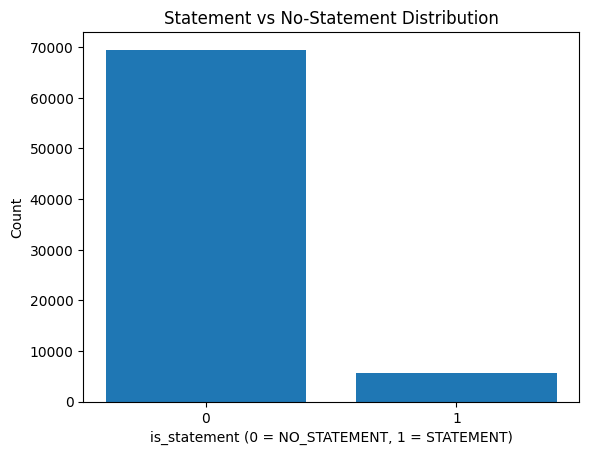

/tmp/ipython-input-2445125705.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_joined.groupby("is_statement", group_keys=False).apply(


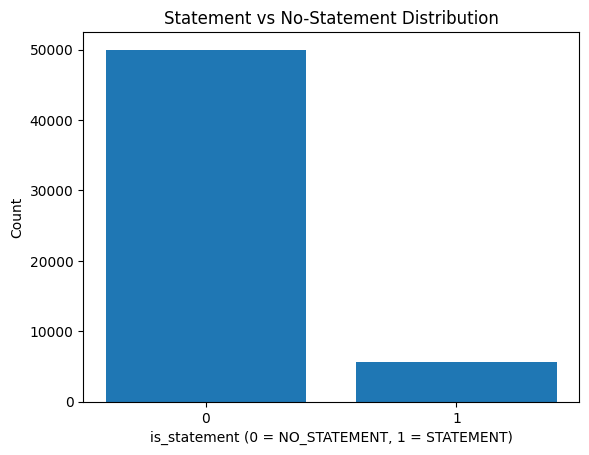

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,label,confidence,is_statement,is_truth
73940,950138,25,7428,0,0,0,we the people should set up a fund for preside...,1,0.970189,0,0.772409,negative,0,0.391836,NO_STATEMENT,0.98,0,0
38162,823139,6,20093,19,2,1,who wants their own personal overwater bungalo...,0,0.004743,1,0.718182,neutral,0,0.028716,NO_STATEMENT,0.99,0,0
41989,833925,33,20387,0,0,0,they are just friggen nuts!! senator klobuchar...,1,0.605827,0,0.884222,negative,1,0.636690,NO_STATEMENT,0.55,0,0
38477,823684,5,502,1,0,0,ric grenell is a snake that pushes the trans a...,0,0.007190,0,0.916576,negative,0,0.062122,NO_STATEMENT,0.75,0,0
72320,941818,28,56992,7,0,0,i guess you all realize the biden sanctioned i...,1,0.987989,0,0.895454,negative,0,0.240426,NO_STATEMENT,0.88,0,0


In [ ]:
# Statment detecktion

counts = df_joined["is_statement"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("is_statement (0 = NO_STATEMENT, 1 = STATEMENT)")
plt.ylabel("Count")
plt.title("Statement vs No-Statement Distribution")
plt.show()


df_train = df_joined.groupby("is_statement", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50000), random_state=42)
)
df_train['text'] = df_train['text'].str.slice(0, 550)
counts = df_train["is_statement"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("is_statement (0 = NO_STATEMENT, 1 = STATEMENT)")
plt.ylabel("Count")
plt.title("Statement vs No-Statement Distribution")
plt.show()
df_train.head()

# Neuer Abschnitt

In [ ]:
class ArXivDataset(Dataset):
    def __init__(self, encodings, labels, extra_features=None):
        self.encodings = encodings
        self.labels = labels
        self.extra_features = extra_features  # NumPy array oder Tensor [num_samples, num_features]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        if self.extra_features is not None:
            item['extra_features'] = torch.tensor(self.extra_features[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)


class WeightedLossTrainer(Trainer):
    """Custom Trainer with optional class weights for imbalanced data"""

    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Accept extra keyword arguments to avoid unexpected argument errors
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply class weights if provided
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


def train_peft_binary_classifier(
    base_model_name,
    df,
    label_name,
    lora_config,
    training_args,
    output_dir,
    use_class_weights=True,
):
    """
    Train a binary classifier with PEFT on imbalanced data.

    Args:
        use_class_weights: Apply inverse class frequency weights to loss

    """

    print("Loading base model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        base_model_name,
        num_labels=2,
        id2label={0: "class_0", 1: "class_1"},
        label2id={"class_0": 0, "class_1": 1}
    )

    # Configure LoRA adapter
    print("Configuring LoRA adapter...")
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    # Encode Data
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    train_df, validation_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[label_name],  # Maintains class distribution
    random_state=42  # For reproducibility
)

    print("Encoding sequences...")
    train_encodings = tokenizer(
        train_df['text'].tolist(),
        truncation=True,
        return_tensors=None
    )

    validation_encodings = tokenizer(
        validation_df['text'].tolist(),
        truncation=True,
        return_tensors=None
    )

    print(f"Training sequences encoded: {len(train_encodings['input_ids'])} samples")
    print(f"Validation sequences encoded: {len(validation_encodings['input_ids'])} samples")

    # Create datasets
    print("Creating datasets...")
    train_labels = train_df[label_name].tolist()
    validation_labels = validation_df[label_name].tolist()

    train_dataset = ArXivDataset(train_encodings, train_labels)
    test_dataset = ArXivDataset(validation_encodings, validation_labels)

    # Calculate class distribution and weights
    unique, counts = np.unique(train_labels, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    print(f"\nClass distribution in training set: {class_distribution}")

    # Calculate class weights (inverse frequency)
    class_weights = None
    if use_class_weights:
        total_samples = len(train_labels)
        class_weights = torch.tensor([
            total_samples / (len(unique) * counts[0]),
            total_samples / (len(unique) * counts[1])
        ], dtype=torch.float32)

        if torch.cuda.is_available():
            class_weights = class_weights.cuda()

        print(f"Class weights: {class_weights.tolist()}")


    # Create data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Define metrics - IMPORTANT: recall for minority class (class 1)
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='binary', pos_label=1)
        precision = precision_score(labels, predictions, average='binary', pos_label=1)
        recall = recall_score(labels, predictions, average='binary', pos_label=1)

        # Also compute per-class metrics
        f1_per_class = f1_score(labels, predictions, average=None)
        recall_per_class = recall_score(labels, predictions, average=None)
        precision_per_class = precision_score(labels, predictions, average=None)

        return {
            "accuracy": accuracy,
            "f1": f1,
            "precision": precision,
            "recall": recall,  # This is recall for class 1 (claims)
            "f1_class_0": f1_per_class[0],
            "f1_class_1": f1_per_class[1],
            "recall_class_0": recall_per_class[0],
            "recall_class_1": recall_per_class[1],  # Same as 'recall' above
            "precision_class_0": precision_per_class[0],
            "precision_class_1": precision_per_class[1]
        }

    # Initialize Trainer (with or without class weights and/or sampler)
    if use_class_weights:
        # Use custom trainer if either class weights or sampler are needed
        trainer = WeightedLossTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
            data_collator=data_collator,
            class_weights=class_weights,
        )
    else:
        # Use standard trainer if no special handling needed
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
            data_collator=data_collator
        )

    # Train the model
    print("\nStarting training...")
    trainer.train()

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = trainer.evaluate(test_dataset)
    print("\n" + "="*60)
    print("FINAL TEST SET RESULTS (Best model based on recall)")
    print("="*60)
    print(f"Test Accuracy:           {test_results['eval_accuracy']:.4f}")
    print(f"Test Recall (Class 1):   {test_results['eval_recall']:.4f} ← PRIMARY METRIC")
    print(f"Test Precision (Class 1): {test_results['eval_precision']:.4f}")
    print(f"Test F1 (Class 1):       {test_results['eval_f1']:.4f}")
    print("-"*60)
    print(f"Class 0 - Recall:        {test_results['eval_recall_class_0']:.4f}")
    print(f"Class 0 - Precision:     {test_results['eval_precision_class_0']:.4f}")
    print(f"Class 0 - F1:            {test_results['eval_f1_class_0']:.4f}")
    print("-"*60)
    print(f"Class 1 - Recall:        {test_results['eval_recall_class_1']:.4f}")
    print(f"Class 1 - Precision:     {test_results['eval_precision_class_1']:.4f}")
    print(f"Class 1 - F1:            {test_results['eval_f1_class_1']:.4f}")
    print("="*60)

    # Save the LoRA adapter
    print("\nSaving LoRA adapter...")
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"\nTraining complete! Adapter saved to {output_dir}")

    # Return results for analysis
    return test_results


# Example usage:
"""
from peft import LoraConfig
from transformers import TrainingArguments

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value"]
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=2e-4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="recall",  # Save best model based on recall for claims
    greater_is_better=True,  # Higher recall is better
    save_total_limit=2,  # Only keep best 2 checkpoints to save disk space
)

results = train_peft_binary_classifier(
    base_model_name="bert-base-uncased",
    train_df=train_df,
    validation_df=validation_df,
    label_name="label",
    lora_config=lora_config,
    training_args=training_args,
    output_dir="./lora_adapter",
    use_class_weights=True,  # Recommended for imbalanced data
    use_weighted_sampling=False
)
"""

'\nfrom peft import LoraConfig\nfrom transformers import TrainingArguments\n\nlora_config = LoraConfig(\n    task_type="SEQ_CLS",\n    r=8,\n    lora_alpha=16,\n    lora_dropout=0.1,\n    target_modules=["query", "value"]\n)\n\ntraining_args = TrainingArguments(\n    output_dir="./results",\n    num_train_epochs=3,\n    per_device_train_batch_size=8,\n    per_device_eval_batch_size=16,\n    evaluation_strategy="epoch",\n    save_strategy="epoch",\n    logging_steps=100,\n    learning_rate=2e-4,\n    weight_decay=0.01,\n    load_best_model_at_end=True,\n    metric_for_best_model="recall",  # Save best model based on recall for claims\n    greater_is_better=True,  # Higher recall is better\n    save_total_limit=2,  # Only keep best 2 checkpoints to save disk space\n)\n\nresults = train_peft_binary_classifier(\n    base_model_name="bert-base-uncased",\n    train_df=train_df,\n    validation_df=validation_df,\n    label_name="label",\n    lora_config=lora_config,\n    training_args=trainin

In [ ]:

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=16,                             # Mehr Kapazität
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value", "key"],  # Mehr Module
    bias="none"
)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/TruthSocial/model_statment",
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=2e-4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="/content/drive/MyDrive/TruthSocial/model_statment/log",           # directory where logs are saved
    report_to="none"  ,
    metric_for_best_model="recall",  # Save best model based on recall for claims
    greater_is_better=True,  # Higher recall is better
    save_total_limit=2,  # Only keep best 2 checkpoints to save disk space
)

results = train_peft_binary_classifier(
    base_model_name="bert-base-uncased",
    df=df_train,
    label_name="is_statement",
    lora_config=lora_config,
    training_args=training_args,
    output_dir="/content/drive/MyDrive/TruthSocial/model_statment/model",
    use_class_weights=True  # Recommended for imbalanced data
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading base model...
Configuring LoRA adapter...
trainable params: 886,274 || all params: 110,370,052 || trainable%: 0.8030
Loading tokenizer...
Encoding sequences...
Training sequences encoded: 44499 samples
Validation sequences encoded: 11125 samples
Creating datasets...

Class distribution in training set: {np.int64(0): np.int64(40000), np.int64(1): np.int64(4499)}
Class weights: [0.556237518787384, 4.945432186126709]

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Class 0,F1 Class 1,Recall Class 0,Recall Class 1,Precision Class 0,Precision Class 1
1,0.419000,0.399106,0.778607,0.447882,0.299460,0.888000,0.861544,0.447882,0.766300,0.888000,0.983823,0.299460
2,0.358600,0.384799,0.813753,0.483292,0.335875,0.861333,0.886404,0.483292,0.808400,0.861333,0.981068,0.335875
3,0.338200,0.378539,0.866517,0.544897,0.415809,0.790222,0.921789,0.544897,0.875100,0.790222,0.973740,0.415809
4,0.310200,0.399002,0.846831,0.524288,0.382173,0.834667,0.908721,0.524288,0.848200,0.834667,0.978542,0.382173
5,0.256000,0.436651,0.840090,0.517755,0.372465,0.848889,0.904154,0.517755,0.839100,0.848889,0.980143,0.372465
6,0.253200,0.423728,0.833169,0.509254,0.362439,0.856000,0.899502,0.509254,0.830600,0.856000,0.980869,0.362439
7,0.237900,0.456375,0.857079,0.535631,0.398869,0.815111,0.915542,0.535631,0.861800,0.815111,0.976433,0.398869


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Class 0,F1 Class 1,Recall Class 0,Recall Class 1,Precision Class 0,Precision Class 1
1,0.419000,0.399106,0.778607,0.447882,0.299460,0.888000,0.861544,0.447882,0.766300,0.888000,0.983823,0.299460
2,0.358600,0.384799,0.813753,0.483292,0.335875,0.861333,0.886404,0.483292,0.808400,0.861333,0.981068,0.335875
3,0.338200,0.378539,0.866517,0.544897,0.415809,0.790222,0.921789,0.544897,0.875100,0.790222,0.973740,0.415809
4,0.310200,0.399002,0.846831,0.524288,0.382173,0.834667,0.908721,0.524288,0.848200,0.834667,0.978542,0.382173
5,0.256000,0.436651,0.840090,0.517755,0.372465,0.848889,0.904154,0.517755,0.839100,0.848889,0.980143,0.372465
6,0.253200,0.423728,0.833169,0.509254,0.362439,0.856000,0.899502,0.509254,0.830600,0.856000,0.980869,0.362439
7,0.237900,0.456375,0.857079,0.535631,0.398869,0.815111,0.915542,0.535631,0.861800,0.815111,0.976433,0.398869
8,0.223400,0.472809,0.852674,0.531313,0.391653,0.825778,0.912601,0.531313,0.855700,0.825778,0.977608,0.391653
9,0.203900,0.508050,0.863011,0.542617,0.409606,0.803556,0.919442,0.542617,0.869700,0.803556,0.975219,0.409606
10,0.181800,0.536596,0.870652,0.552967,0.425024,0.791111,0.924387,0.552967,0.879600,0.791111,0.973979,0.425024



Evaluating on test set...



FINAL TEST SET RESULTS (Best model based on recall)
Test Accuracy:           0.7786
Test Recall (Class 1):   0.8880 ← PRIMARY METRIC
Test Precision (Class 1): 0.2995
Test F1 (Class 1):       0.4479
------------------------------------------------------------
Class 0 - Recall:        0.7663
Class 0 - Precision:     0.9838
Class 0 - F1:            0.8615
------------------------------------------------------------
Class 1 - Recall:        0.8880
Class 1 - Precision:     0.2995
Class 1 - F1:            0.4479

Saving LoRA adapter...

Training complete! Adapter saved to /content/drive/MyDrive/TruthSocial/model_statment/model


In [ ]:
#load best lora
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
import torch

def predict_label(abstract_text, model, tokenizer, adapter_name):
  # Set the desired adapter
  model.set_adapter(adapter_name)

  # Tokenize the input abstract
  inputs = tokenizer(
      abstract_text,
      return_tensors="pt",
      truncation=True,
      padding=True
  )

  # Move inputs to the same device as the model
  device = model.device
  inputs = {key: value.to(device) for key, value in inputs.items()}

  # Perform inference
  with torch.no_grad():
    outputs = model(**inputs)
  logits = outputs.logits
  predicted_label = torch.argmax(logits, dim=-1).item()
  propabilities = torch.softmax(logits, dim=-1)
  propabilities = propabilities[0, 1].item()
  return predicted_label, propabilities

def predict_statment(text, model, tokenizer, adapter_name):
  if len(text) > 30:
    predicted_label, propabilities = predict_label(text, model, tokenizer, adapter_name)
  else:
    predicted_label = 0
    propabilities = -1
  return predicted_label, propabilities

  # Set the desired adapter

model_name = "bert-base-uncased" # Ensure model_name is defined
base_model = AutoModelForSequenceClassification.from_pretrained(
      model_name,
  )
tokenizer = AutoTokenizer.from_pretrained(model_name)
multi_adapter_model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/TruthSocial/model_statment/model", adapter_name= "label_statment")
multi_adapter_model.eval()

# Check if CUDA is available and move model to GPU, otherwise use CPU
if torch.cuda.is_available():
    multi_adapter_model.to('cuda')
else:
    multi_adapter_model.to('cpu')

result, propabilities = predict_statment("The mount everest is a mountain in italy and is the biggest mountain in europa", multi_adapter_model, tokenizer, "label_statment")
print(result)
print(propabilities)


result, propabilities = predict_statment("I love my cat, she is my bes friend", multi_adapter_model, tokenizer, "label_statment")
print(result)
print(propabilities)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1
0.961475670337677
0
0.030056823045015335


In [ ]:
import torch
import pandas as pd
from tqdm import tqdm

def predict_batch(texts, model, tokenizer, adapter_name, batch_size=32, device=None):
    model.set_adapter(adapter_name)
    model.eval()

    if device is None:
        device = next(model.parameters()).device

    all_labels = []
    all_probs = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)

        # assuming binary classifier: [not_statement, statement]
        batch_probs = probs[:, 1].detach().cpu().numpy()
        batch_labels = (batch_probs >= 0.5).astype(int)

        all_probs.extend(batch_probs.tolist())
        all_labels.extend(batch_labels.tolist())

    return all_labels, all_probs

texts = truth_df["text"].astype(str).tolist()
# run batch prediction
labels, probs = predict_batch(
    texts,
    model=multi_adapter_model,
    tokenizer=tokenizer,
    adapter_name="label_statment",
    batch_size=32
)

truth_df["statement_flag"] = labels
truth_df["statement_probability"] = probs

truth_df.to_csv(
    "/content/drive/MyDrive/TruthSocial/truth_cleand.csv",
    index=False
)


100%|██████████| 20512/20512 [31:07<00:00, 10.98it/s]


In [ ]:
#new data
new_df = pd.read_csv("/content/drive/MyDrive/TruthSocial/truth_labels_prefilterd_gpt5.csv")
new_df.head()

,Unnamed: 0,id,TRUE,FALSE,NO_STATEMENT,truth_label
0,0,807621,0.02,0.08,0.90,NO_STATEMENT
1,1,703306,0.05,0.05,0.90,NO_STATEMENT
2,2,703308,0.05,0.60,0.35,FALSE
3,3,703394,0.15,0.15,0.70,NO_STATEMENT
4,4,703282,0.02,0.08,0.90,NO_STATEMENT


In [ ]:
label_cols = ["TRUE", "FALSE", "NO_STATEMENT"]
new_df["confidence"] = new_df[label_cols].max(axis=1)
new_df["label"] = new_df['truth_label']
new_df_formatted = new_df[["id", "label", "confidence"]]
new_df_formatted.head()

,id,label,confidence
0,807621,NO_STATEMENT,0.9
1,703306,NO_STATEMENT,0.9
2,703308,FALSE,0.6
3,703394,NO_STATEMENT,0.7
4,703282,NO_STATEMENT,0.9


In [ ]:
combined_df = pd.concat(
    [weak_labels, new_df_formatted],
    ignore_index=True
)
combined_df.head()

,id,label,confidence
0,703265,NO_STATEMENT,0.98
1,807621,NO_STATEMENT,0.93
2,703273,NO_STATEMENT,0.98
3,703274,NO_STATEMENT,0.98
4,703305,NO_STATEMENT,0.98


In [ ]:
df_joined = pd.merge(truth_df, combined_df, on='id', how='inner')
df_joined["is_statement"] = (df_joined["label"] != "NO_STATEMENT").astype(int)
df_joined["is_truth"] = (df_joined["label"] == "TRUE").astype(int)
df_size = df_joined.shape[0]
print(df_size)
df_joined.head()

100149


,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,label,confidence,is_statement,is_truth
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,0.851504,neutral,0,0.010807,NO_STATEMENT,0.98,0,0
1,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,NO_STATEMENT,0.93,0,0
2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,NO_STATEMENT,0.90,0,0
3,703273,25,11225,1,0,3,when you see these things happening..you know ...,0,0.002214,2,0.891358,positive,0,0.029900,NO_STATEMENT,0.98,0,0
4,703274,25,11225,1,0,1,if anyone has not got the spirit christ..they ...,1,0.972849,0,0.786279,negative,0,0.393012,NO_STATEMENT,0.98,0,0


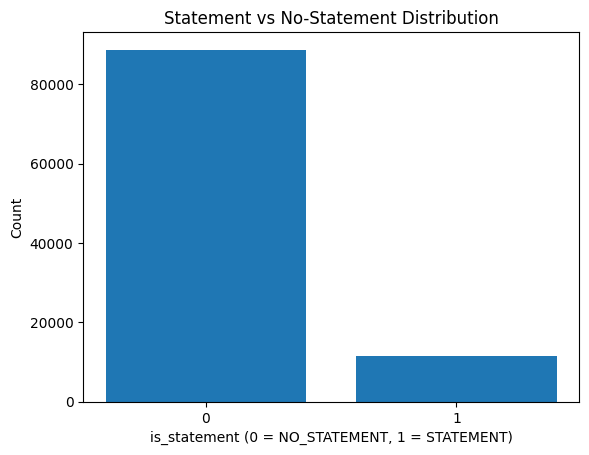

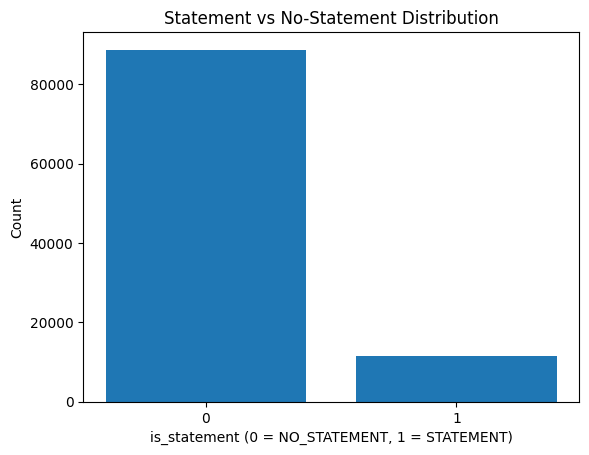

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,sentiment_conf,sentiment,statement_flag,statement_probability,label,confidence,is_statement,is_truth
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,0.851504,neutral,0,0.010807,NO_STATEMENT,0.98,0,0
1,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,NO_STATEMENT,0.93,0,0
2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,0.817848,negative,1,0.519844,NO_STATEMENT,0.90,0,0
3,703273,25,11225,1,0,3,when you see these things happening..you know ...,0,0.002214,2,0.891358,positive,0,0.029900,NO_STATEMENT,0.98,0,0
4,703274,25,11225,1,0,1,if anyone has not got the spirit christ..they ...,1,0.972849,0,0.786279,negative,0,0.393012,NO_STATEMENT,0.98,0,0


In [ ]:
# Statment detecktion

counts = df_joined["is_statement"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("is_statement (0 = NO_STATEMENT, 1 = STATEMENT)")
plt.ylabel("Count")
plt.title("Statement vs No-Statement Distribution")
plt.show()


df_train = df_joined
df_train['text'] = df_train['text'].str.slice(0, 550)
counts = df_train["is_statement"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("is_statement (0 = NO_STATEMENT, 1 = STATEMENT)")
plt.ylabel("Count")
plt.title("Statement vs No-Statement Distribution")
plt.show()
df_train.head()

In [ ]:

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=16,                             # Mehr Kapazität
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value", "key"],  # Mehr Module
    bias="none"
)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/TruthSocial/model_statment_new",
    num_train_epochs=10,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=2e-4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="/content/drive/MyDrive/TruthSocial/model_statment/log_new",           # directory where logs are saved
    report_to="none"  ,
    metric_for_best_model="f1_class_1",  # Save best model based on recall for claims
    greater_is_better=True,  # Higher recall is better
    save_total_limit=2,  # Only keep best 2 checkpoints to save disk space
)

results = train_peft_binary_classifier(
    base_model_name="bert-base-uncased",
    df=df_train,
    label_name="is_statement",
    lora_config=lora_config,
    training_args=training_args,
    output_dir="/content/drive/MyDrive/TruthSocial/model_statment/model_new",
    use_class_weights=True  # Recommended for imbalanced data
)


Loading base model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configuring LoRA adapter...
trainable params: 886,274 || all params: 110,370,052 || trainable%: 0.8030
Loading tokenizer...
Encoding sequences...
Training sequences encoded: 80119 samples
Validation sequences encoded: 20030 samples
Creating datasets...

Class distribution in training set: {np.int64(0): np.int64(70968), np.int64(1): np.int64(9151)}
Class weights: [0.5644727349281311, 4.377608776092529]

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Class 0,F1 Class 1,Recall Class 0,Recall Class 1,Precision Class 0,Precision Class 1
1,0.432000,0.434466,0.769496,0.458797,0.313471,0.855332,0.853563,0.458797,0.758426,0.855332,0.975992,0.313471
2,0.407500,0.428370,0.772691,0.469038,0.319866,0.878934,0.855391,0.469038,0.758990,0.878934,0.979844,0.319866
3,0.383000,0.441740,0.777334,0.476403,0.325682,0.886801,0.858601,0.476403,0.763217,0.886801,0.981232,0.325682
4,0.345500,0.418764,0.793809,0.487847,0.340547,0.859703,0.870921,0.487847,0.785312,0.859703,0.977480,0.340547
5,0.337400,0.433381,0.810934,0.506965,0.361024,0.850962,0.883041,0.506965,0.805772,0.850962,0.976703,0.361024
6,0.313700,0.441112,0.818922,0.514523,0.370828,0.840035,0.888705,0.514523,0.816199,0.840035,0.975349,0.370828
7,0.279900,0.455272,0.807988,0.501684,0.356538,0.846154,0.881083,0.501684,0.803066,0.846154,0.975890,0.356538
8,0.294700,0.501412,0.840389,0.535387,0.401045,0.805070,0.903644,0.535387,0.844944,0.805070,0.971108,0.401045
9,0.249800,0.507051,0.840939,0.536514,0.402093,0.805944,0.903996,0.536514,0.845451,0.805944,0.971251,0.402093
10,0.270700,0.513680,0.842486,0.538000,0.404536,0.802885,0.905059,0.538000,0.847593,0.802885,0.970883,0.404536



Evaluating on test set...



FINAL TEST SET RESULTS (Best model based on recall)
Test Accuracy:           0.8425
Test Recall (Class 1):   0.8029 ← PRIMARY METRIC
Test Precision (Class 1): 0.4045
Test F1 (Class 1):       0.5380
------------------------------------------------------------
Class 0 - Recall:        0.8476
Class 0 - Precision:     0.9709
Class 0 - F1:            0.9051
------------------------------------------------------------
Class 1 - Recall:        0.8029
Class 1 - Precision:     0.4045
Class 1 - F1:            0.5380

Saving LoRA adapter...

Training complete! Adapter saved to /content/drive/MyDrive/TruthSocial/model_statment/model_new
